# **Dictionary Methods**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sekhansen/text_algorithms_econ/blob/main/notebooks/1_regex_dictionary.ipynb)

This notebook illustrates how to use list of terms (i.e. dictionaries) to measure certain aspects of text data. Particularly, we will show how to build an index that captures the sentiment of policymakers towards the economy. Methodologically, we will use regular expressions to count the number of appereances of words in the text.

In [ ]:
import pandas as pd
import numpy as np
import gdown
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# define paths and seed
seed = 92
data_path = "./"

In [ ]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"mpc_minutes":             ("https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR", "txt"),
                 "ons_quarterly_gdp":       ("https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD", "csv")
                 }

In [ ]:
# download each file in the dictionary from Google Drive
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR
To: /content/mpc_minutes.txt
100%|██████████| 7.36M/7.36M [00:00<00:00, 204MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD
To: /content/ons_quarterly_gdp.csv
100%|██████████| 3.33k/3.33k [00:00<00:00, 6.78MB/s]


# 0. Load data

This tutorial uses text data from the monetary policy discussions at the Bank of England. Concretely, we use the minutes from the monthly [Monetary Policy Committee](https://www.bankofengland.co.uk/about/people/monetary-policy-committee) meetings. You can browse through all of these minutes [here]((https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/monetary-policy-summary-and-minutes) or explore one particular minute from September 2017 [here](https://www.bankofengland.co.uk/-/media/boe/files/monetary-policy-summary-and-minutes/2017/september-2017.pdf?la=en&hash=48D5F5B648234CFF1EE2AF02A05181107459E0A2).

As a first step, we inspect the data. We observe that we have a total number of 7,277 strings of data (hereafter **documents**) with an associated date (YYYYMM) that ranges between 06/1997 and 10/2014. The average length of a document is roughly 161 words.

In [ ]:
data = pd.read_csv(data_path + 'mpc_minutes.txt', delimiter='\t', header=0, names=['date', 'minutes'])
print(data.shape)
data.head()

(7277, 2)


,date,minutes
0,199706,1 Sections I to V of this minute summarise t...
1,199706,The 12-month growth rate of notes and coins ...
2,199706,"Broad money, too, decelerated in April: its ..."
3,199706,Lending growth continued at around 9% in ...
4,199706,Lending to individuals remained robust in...


In [ ]:
# turn date into date format and create quarter column
data['date'] = pd.to_datetime(data.date, format='%Y%m')
data['year'] = data.date.dt.year.astype(int)
data['quarter'] = data.date.dt.quarter.astype(int)
data['date'] = data['date'].dt.strftime('%Y%m')
data.head()

,date,minutes,year,quarter
0,199706,1 Sections I to V of this minute summarise t...,1997,2
1,199706,The 12-month growth rate of notes and coins ...,1997,2
2,199706,"Broad money, too, decelerated in April: its ...",1997,2
3,199706,Lending growth continued at around 9% in ...,1997,2
4,199706,Lending to individuals remained robust in...,1997,2


In [ ]:
# get a sense of the number of words per document
data['length'] = data.minutes.apply(lambda x: len(x.split()))
print(f'average document length: {np.round(np.mean(data.length),0)} words')

average document length: 161.0 words


In [ ]:
# inspect the coverage of our data
print('n. months:', len(data.date.unique()))
print('n. years:', len(data.year.unique()))

n. months: 209
n. years: 18


# 1. Applying a sentiment dictionary

Consider a situation where we want to investigate the overall sentiment of each monetary policy meeting. This migth be a very interesting quantity since it reflects the perception that policy makers have of the current state of the economy.
<br><br>

A simple and sensible way to estimate this quantity would be to build a document-sentiment index based on the difference between the number of words having a "positive" sentiment and those having a "negative" sentiment in a document. For each document  $i$ we could calculate:
<br><br>

$$
\text{sentiment}_i = \frac{{\text{# Positive terms}_i} - \text{# Negative terms}_i}{{\text{# Positive terms}_i} + \text{# Negative terms}_i}
$$

<br><br>


**We will do precisely this at the year-quarter level** and will then evaluate the resulting index by comparing it with the UK's GDP growth.

Firstly, we need to define the terms having positive or negative sentiment. For this example, we use a set of terms from [Apel and Blix-Grimaldi (2012)](http://archive.riksbank.se/Documents/Rapporter/Working_papers/2012/rap_wp261_120426.pdf) who analyzed the minutes from the Swedish Central Bank. In general, it is a good practice to build on dictionaries that have been already used in the literature.

In [ ]:
pos_words = ["high", "higher", "highest",
             "strong", "stronger", "strongest",
             "increase", "increases", "increased", "increasing",
             "fast", "faster", "fastest"]

In [ ]:
neg_words = ["low", "lower", "lowest",
             "weak", "weaker", "weakest",
             "decrease", "decreases", "decreased", "decreasing",
             "slow", "slower", "slowest"]

We can immediately notice that the dictionaries are lowercased, while the minutes data is not. When searching the minutes for sentiment terms, we do not want casing to interefere. Therefore, it is a good idea to lower-case the minutes data first. To do so, we can call the method ```lower()``` on each string. 

In [ ]:
# lowercase all text
data['minutes_lower'] = data.minutes.apply(lambda x: x.lower())

By using regular expressions, we can now count the number of times a positive or negative words was used in each of the minutes.

In [ ]:
# function for counting the number of words from a list that appear on a give text
def count_instances(text, target_list):
    target_string = '|'.join(target_list)
    matches = re.findall(fr"\b({target_string})\b", text)
    return len(matches)

In [ ]:
# apply counting function
data['pos_counts'] = data.minutes_lower.apply(lambda x: count_instances(text=x, target_list=pos_words))
data['neg_counts'] = data.minutes_lower.apply(lambda x: count_instances(text=x, target_list=neg_words))

We can now compute sentiment at the year-quarter level, and compare it to the UK's GDP growth.

In [ ]:
# aggregate all minutes to the year-quarter level (by summing all the counts)
data_agg = data.loc[:, ['year', 'quarter', 'pos_counts', 'neg_counts']].groupby(['year', 'quarter']).sum()

In [ ]:
# compute sentiment at year-quarter level
data_agg['sentiment'] = (data_agg.pos_counts - data_agg.neg_counts)/(data_agg.pos_counts + data_agg.neg_counts)
data_agg.head()

pos_counts  neg_counts  sentiment
year quarter                                   
1997 2                27          10   0.459459
     3               222          72   0.510204
     4               229          86   0.453968
1998 1               254         114   0.380435
     2               255         132   0.317829

In [ ]:
# load GPD growth data
ons = pd.read_csv(data_path + 'ons_quarterly_gdp.csv', names=['label', 'gdp_growth', 'quarter_long'], header=0)

ons['year'] = ons.label.apply(lambda x: x[:4]).astype(int)
ons['quarter'] = ons.label.apply(lambda x: x[6]).astype(int)

ons = ons[['year', 'quarter', 'gdp_growth']]

ons = ons.drop_duplicates().reset_index(drop=True).copy()
ons.head()

,year,quarter,gdp_growth
0,1997,2,1.2
1,1997,3,0.6
2,1997,4,1.3
3,1998,1,0.6
4,1998,2,0.6


In [ ]:
# merge to sentiment data
df = data_agg.merge(ons, how='left', on=['year', 'quarter']).reset_index(drop=True).copy()
df.head()

,year,quarter,pos_counts,neg_counts,sentiment,gdp_growth
0,1997,2,27,10,0.459459,1.2
1,1997,3,222,72,0.510204,0.6
2,1997,4,229,86,0.453968,1.3
3,1998,1,254,114,0.380435,0.6
4,1998,2,255,132,0.317829,0.6


In [ ]:
# # save for later use
# df = df[['year', 'quarter', 'sentiment', 'gdp_growth']].copy()
# df.to_csv(data_path + 'gdp_sentiment.csv')

In [ ]:
# explore the correlation between sentiment and GDP
print(df[['sentiment', 'gdp_growth']].corr())

            sentiment  gdp_growth
sentiment    1.000000    0.271934
gdp_growth   0.271934    1.000000


In spite of its arguable lack of subtlety, here dictionary methods have produced a sentiment indicator that indeed correlates with real activity. Below we plot standardized series for growth and sentiment.

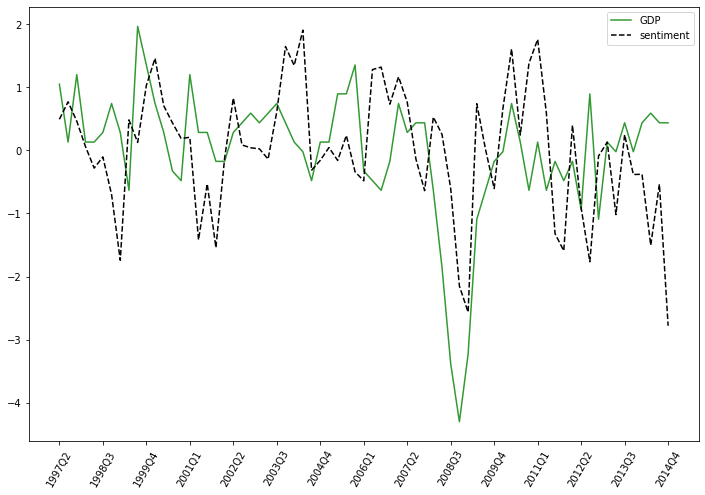

In [ ]:
# plot both time series (after standardizing them)
scaler = StandardScaler()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)).flatten(), 
        label='GDP', c='green', alpha=0.8)
ax.plot(scaler.fit_transform(df.sentiment.values.reshape(-1, 1)).flatten(), 
        label='sentiment', linestyle='dashed', c='black')

ticks = np.arange(0, df.shape[0], 5)
labs = np.array([str(x)+'Q'+str(y) for x,y in zip(df['year'],df['quarter'])])
labs = labs[ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labs, rotation=60)
ax.legend()

plt.show()